<br>

<div align=center><font color=maroon size=6 style="line-height:40px;"><b>Video Inbetweening using 3D Convolutions</b></font></div>

<br>

<font size=4><b>References:</b></font>
1. TensorFlow > <a href="https://www.tensorflow.org/resources" style="text-decoration:none;">Resources</a> 
    * `TensorFlow > Resources > Hub > Tutorials > `<a href="https://www.tensorflow.org/hub/tutorials/tweening_conv3d" style="text-decoration:none;">Video Inbetweening using 3D Convolutions</a>
        * Run in <a href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tweening_conv3d.ipynb" style="text-decoration:none;">Google Colab</a>

<br>
<br>
<br>

Yunpeng Li, Dominik Roblek, and Marco Tagliasacchi. From Here to There: Video Inbetweening Using Direct 3D Convolutions, 2019.

https://arxiv.org/abs/1905.10240


Current Hub characteristics:
- has models for BAIR Robot pushing videos and KTH action video dataset (though this colab uses only BAIR)
- BAIR dataset already available in Hub. However, KTH videos need to be supplied by the users themselves.
- only evaluation (video generation) for now
- batch size and frame size are hard-coded


<br>

## Setup

Since `tfds.load('bair_robot_pushing_small', split='test')` would download a 30GB archive that also contains the training data, we download a separated archive that only contains the 190MB test data. The used dataset has been published by [this paper](https://arxiv.org/abs/1710.05268) and is licensed as Creative Commons BY 4.0.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow_datasets.core import SplitGenerator
from tensorflow_datasets.video.bair_robot_pushing import BairRobotPushingSmall

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tempfile
import pathlib

In [2]:
print(tf.__version__)

2.8.0


In [3]:
TEST_DIR = pathlib.Path(tempfile.mkdtemp())
TEST_DIR

WindowsPath('C:/Users/18617/AppData/Local/Temp/tmpywmnnzd6')

In [4]:
# Download the test split to $TEST_DIR
!mkdir -p $TEST_DIR
!wget -nv https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

A subdirectory or file C:\Users\18617\AppData\Local\Temp\tmpywmnnzd6 already exists.
Error occurred while processing: C:\Users\18617\AppData\Local\Temp\tmpywmnnzd6.
'wget' is not recognized as an internal or external command,
operable program or batch file.


<br>

In [5]:
# 针对上面：'wget' is not recognized as an internal or external command, operable program or batch file.
# 参考文献：
# https://stackoverflow.com/questions/60760049/wget-is-not-recognized-as-an-internal-or-external-command-operable-program-or-b

!pip install wget

# 安装之后，下面这样子实用是不对的。
# !wget -nv https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords
# 正确用法请见下面：
# !python -m wget https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords C:/Users/18617/AppData/Local/Temp/tmpywmnnzd6/traj_0_to_255.tfrecords


# 也可以安装 Windows 版本的 wget
# https://adamtheautomator.com/python-wget/

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9677 sha256=09c338aa3607b255a35becd43d91fef28616244e616c758b5a6c4b5670217099
  Stored in directory: c:\users\18617\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


'wget' is not recognized as an internal or external command,
operable program or batch file.


<br>
<br>
<br>

In [6]:
!python -m wget -nv https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

Usage: wget.py [options]

wget.py: error: no such option: -n


In [7]:
!python -m wget -v https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

Usage: wget.py [options]

wget.py: error: no such option: -v


In [8]:
!python -m wget https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

Usage: wget.py [options]

wget.py: error: no such option: -O


<br>

In [ ]:
# Wget 的 options 参考：
# GNU Wget 1.21.1-dirty Manual
# https://www.gnu.org/software/wget/manual/wget.html#Option-Syntax

In [10]:
!python -m wget --version

wget.py 3.2


In [12]:
try:
    wget --version
except Exception as e:
    print(e)

name 'wget' is not defined


In [13]:
!wget --version

'wget' is not recognized as an internal or external command,
operable program or batch file.


<br>
<br>
<br>

In [9]:
!python -m wget https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords $TEST_DIR/traj_0_to_255.tfrecords


Saved under bair_test_traj_0_to_255.tfrecords


In [14]:
TEST_DIR

WindowsPath('C:/Users/18617/AppData/Local/Temp/tmpywmnnzd6')

In [16]:
!python -m wget https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords  C:/Users/18617/AppData/Local/Temp/tmpywmnnzd6/traj_0_to_255.tfrecords


Saved under bair_test_traj_0_to_255 (1).tfrecords


In [18]:
# 目前采用的做法
# 将下载下来的 bair_test_traj_0_to_255.tfrecords
# 手动移动到 C:/Users/18617/AppData/Local/Temp/tmpywmnnzd6/traj_0_to_255.tfrecords
# 不然下一个 cell 将会报错：
# 。。。
# AssertionError: No examples were yielded.

<br>

In [19]:
# Since the dataset builder expects the train and test split to be downloaded,
# patch it so it only expects the test data to be available
builder = BairRobotPushingSmall()
test_generator = SplitGenerator(name='test', gen_kwargs={"filedir": str(TEST_DIR)})
builder._split_generators = lambda _: [test_generator]
builder.download_and_prepare()

Generating splits...:   0%|                                                                 | 0/1 [00:00<?, ? splits/s]
Generating test examples...: 0 examples [00:00, ? examples/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

Generating test examples...: 1 examples [00:01,  1.81s/ examples]
Generating test examples...: 4 examples [00:01,  2.61 examples/s]
Generating test examples...: 7 examples [00:02,  4.91 examples/s]
Generating test examples...: 9 examples [00:02,  6.58 examples/s]
Generating test examples...: 12 examples [00:02,  9.28 examples/s]
Generating test examples...: 14 examples [00:02, 10.87 examples/s]
Generating test examples...: 17 examples [00:02, 13.31 examples/s]
Generating test examples...: 20 examples [00:02, 15.17 examples/s]
Generating test examples...: 22 examples [00:02, 16.12 examples/s]
Generating test examples...: 24 examples [00:02, 16.76 examples/s]
Generating test examples...: 27 examples [00:03, 17.96 examples/s]
Generating test examples...: 30 examples [00:03, 18.68 examples/s]
Generating test examples...: 33 examples [00:03, 19.45 examples/s]
Generating test examples...: 36 examples [00:03

Dataset bair_robot_pushing_small downloaded and prepared to C:\Users\18617\tensorflow_datasets\bair_robot_pushing_small\2.0.0. Subsequent calls will reuse this data.


<br>
<br>
<br>

## BAIR: Demo based on numpy array inputs

### Load some example data (BAIR).

In [20]:
# @title Load some example data (BAIR).
batch_size = 16

# If unable to download the dataset automatically due to "not enough disk space", please download manually to Google Drive and
# load using tf.data.TFRecordDataset.
ds = builder.as_dataset(split="test")
test_videos = ds.batch(batch_size)
first_batch = next(iter(test_videos))
input_frames = first_batch['image_aux1'][:, ::15]
input_frames = tf.cast(input_frames, tf.float32)

<br>
<br>

### Visualize loaded videos start and end frames.

Test videos shape [batch_size, start/end frame, height, width, num_channels]:  (16, 2, 64, 64, 3)


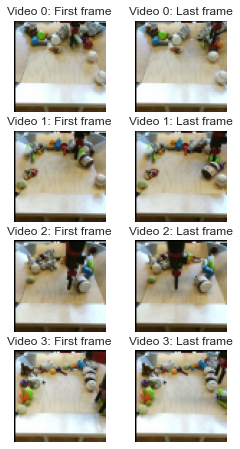

In [21]:
# @title Visualize loaded videos start and end frames.

print('Test videos shape [batch_size, start/end frame, height, width, num_channels]: ', input_frames.shape)
sns.set_style('white')
plt.figure(figsize=(4, 2*batch_size))

for i in range(batch_size)[:4]:
    plt.subplot(batch_size, 2, 1 + 2*i)
    plt.imshow(input_frames[i, 0] / 255.0)
    plt.title('Video {}: First frame'.format(i))
    plt.axis('off')
    plt.subplot(batch_size, 2, 2 + 2*i)
    plt.imshow(input_frames[i, 1] / 255.0)
    plt.title('Video {}: Last frame'.format(i))
    plt.axis('off')
plt.show()

<br>
<br>
<br>

## Load Hub Module

In [22]:
hub_handle = 'https://tfhub.dev/google/tweening_conv3d_bair/1'
module = hub.load(hub_handle).signatures['default']

<br>
<br>
<br>

### Generate and show the videos

In [23]:
filled_frames = module(input_frames)['default'] / 255.0

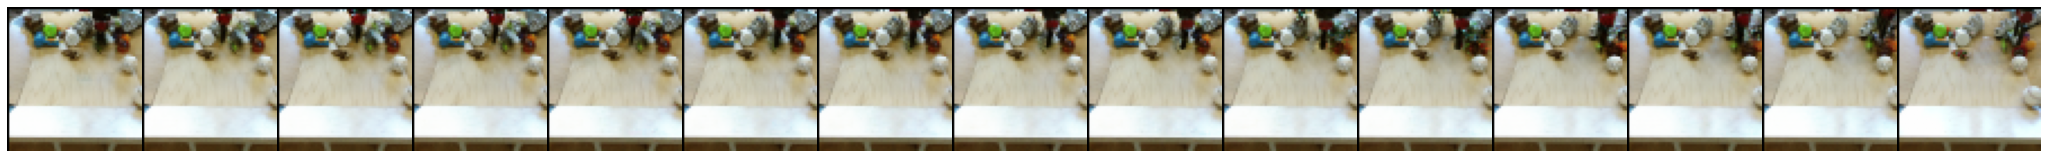

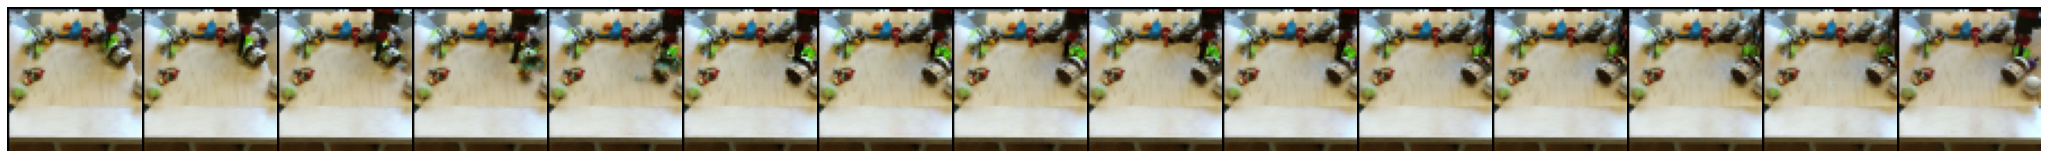

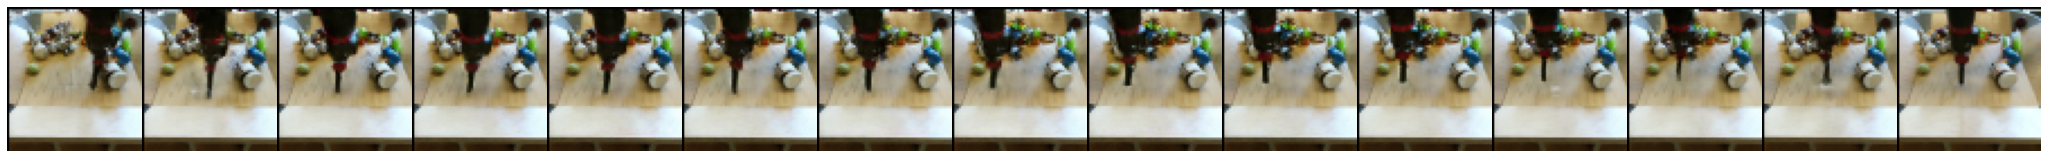

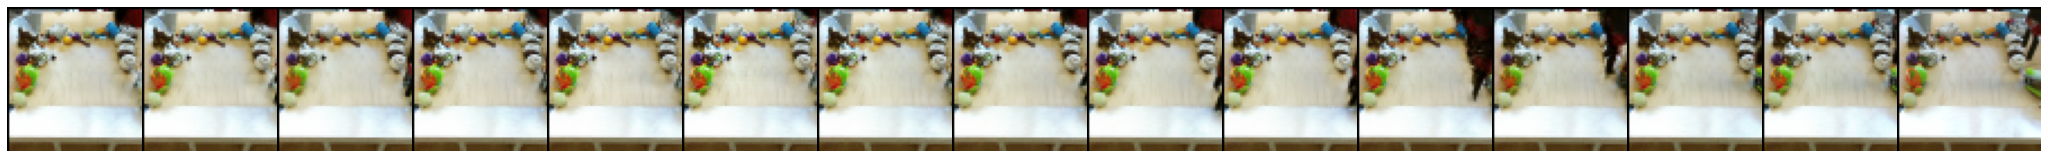

In [24]:
# Show sequences of generated video frames.

# Concatenate start/end frames and the generated filled frames for the new videos.
generated_videos = np.concatenate([input_frames[:, :1] / 255.0, filled_frames, input_frames[:, 1:] / 255.0], axis=1)

for video_id in range(4):
    fig = plt.figure(figsize=(10 * 2, 2))
    for frame_id in range(1, 16):
        ax = fig.add_axes([frame_id * 1 / 16., 0, (frame_id + 1) * 1 / 16., 1],
                          xmargin=0, ymargin=0)
        ax.imshow(generated_videos[video_id, frame_id])
        ax.axis('off')
plt.show()

<font style="color:maroon;font-size:120%">

<br>

**Copyright 2019 The TensorFlow Hub Authors.**

Licensed under the Apache License, Version 2.0 (the "License");

```python
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
```

<br>
<br>
<br>